# **07MIAR - PROYECTO DE PROGRAMACIÓN**

* Guido Alexander Heienbrok
* Oscar García González
* Bruno González Fernández

**DATASET**: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

**OBJETIVOS**: Evaluar y comparar dos estrategias para la clasificación de imágenes empleando el dataset asignado. Los alumnos deberá resolver el reto proponiendo una solución válida basada en aprendizaje profundo, más concretamente en redes neuronales convolucionales (CNNs).  Será indispensable que la solución propuesta siga el pipeline visto en clase para resolver este tipo de tareas de inteligencia artificial:

1. **Carga** del conjunto de datos
2. **Inspección** del conjunto de datos
3. **Acondicionamiento** del conjunto de datos
4. Desarrollo de la **arquitectura*** de red neuronal y **entrenamiento** de la solución
5. **Monitorización** del proceso de entrenamiento para la toma de decisiones
6. **Evaluación** del modelo predictivo y planteamiento de la siguiente prueba experimental

# ÍNDICE

0. Metodología
1. Configuración
2. Imports y funciones base
3. Descarga del dataset
4. Exploración y preprocesado
    - 4.1 Obtener datos train, validation y test
    - 4.2 Visualizar Formato
    - 4.3 Normalizar
    - 4.4 Visualizar muestras
    - 4.5 Pasar etiquetas a OHE
    - 4.6 Data augmentation: flow_from_directory()
5. Estrategia 1: Entrenar from scratch
    - 5.1 MLP
        - 5.1.1 MLP Base
        - 5.1.2 MLP Regularizado
            - a) Dropout
            - b) Regularization L1 o L2
            - c) Data Augmentation
    - 5.2 CNNs
        - 5.2.1 Función arquitectura CNN
        - 5.2.2 1CNN
        - 5.2.3 2CNN
        - 5.2.4 3CNN
            - a) original
            - b) Batch Normalization
            - c) CNN + Data Augmentation + Batch Norm
6. Estrategia 2: Red pre-entrenada
    - 6.1 Transfer Learning
        - 6.1.1 VGG16
            - a) Original
            - b) Data Augmentation
        - 6.1.2 Xception
        - 6.1.3 InceptionV3
        - 6.1.4 ResNet50
    - 6.2 Fine Tuning parcial
        - 6.2.1 VGG16
    - 6.3 Fine Tuning Completo
        - 6.3.1 VGG16
7. Exportación de Resultados
8. Conclusiones


# **0. Metodología**

El proyecto se compone de 3 fases: preparación de los datos, desarrollo y entrenamiento de modelos utilizando redes neuronales from scratch, desarrollo y entrenamiento de modelos utilizando redes neuronales pre-entrenadas.

Se pone el foco en la comparativa de diferentes arquitecturas y técnicas de regularización y data augmentation: MLP, CNN, y varias redes pre-entrenadas (VGG16, Xception, InceptionV3, y ResNet50) siguiendo estrategias de transfer learning y fine tuning (parcial y completo).

Todos los apartados incluyen funciones que soportan las arquitecturas sobre las que se ejecutan los entrenamientos de los diferentes experimentos. Los modelos se guardan para facilitar su análisis y repartir las tareas de entrenamiento entre los miembros del equipo.

Los entrenamientos incluye un callback de parada temprana (*early stopping*) a partir de una epoch predefinida para controlar la convergencia y el sobreajuste de los modelos.

# **1. Configuración** <a id='seccion1'></a>

En esta sección se fijan los hiperparámetros generales que regulan todo el notebook.

**DATOS**

- **BASE_FOLDER**: carperta en la que se guardan los modelos, datos y resultados.
- **MODEL_PATH**: carperta en la que se guardan los modelos.
- **dataset_name**: nombre del dataset de kaggle correspondiente a este proyecto.

**ARQUITECTURAS**

- **target_size**: tramaño de entrada de las imágenes, fijado en 75x75 pixels.
- **dense_size**: tamaño de capas densas de entrada.
- **conv2d_size**: tamaño de capas convolucionales de entrada.  

**ENTRENAMIENTO**

- **batch_size**: número de instancias que se introducen en las redes para que en cada actualización durante el entrenamiento.
- **learning_rate**: tasa de aprendizaje.
- **epochs**: número de épocas máximo con el que se entrenen las redes.
- **early_stopping_patience**: número de épocas sin mejora después de las cuales se detendrá el entrenamiento cuando se utilice el callback de parada temprana.
- **early_stopping_monitor**: métrica a monitorizar  
- **start_from_epoch**: número de épocas a esperar antes de comenzar a monitorear con el callback de parada temprana (early stopping).

In [ ]:
# # CONFIGURACIÓN EXPERIMENTOS

# from google.colab import drive
# drive.mount('/content/drive')

# BASE_FOLDER = "/content/drive/MyDrive/07MIAR_Proyecto_Programacion/"
# MODEL_PATH = "Models"

# dataset_name = "misrakahmed/vegetable-image-dataset"

# CONFIGURACIÓN EXPERIMENTOS
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_FOLDER = "/content/drive/MyDrive/VIU/07_DeepL_NNet/07MIAR_Carpeta_Compartida/"
dataset_name = "misrakahmed/vegetable-image-dataset"

Mounted at /content/drive


**ARQUITECTURAS**

- **target_size**: tramaño de entrada de las imágenes, fijado en 75x75 pixels.
- **dense_size**: tamaño de capas densas de entrada.
- **conv2d_size**: tamaño de capas convolucionales de entrada.  

**ENTRENAMIENTO**
- **do_training**: flag para entrenar modelo o leerlo de la carpeta Models, para que funcione el modelo tendrá que haber sido entrenado previamente (facilita el trabajo en equipo y la reproducibilidad de resultados, repartiendo la carga de entrenamiento entre todos los miembros del equpo).
- **batch_size**: número de instancias que se introducen en las redes para que en cada actualización durante el entrenamiento.
- **learning_rate**: tasa de aprendizaje.
- **epochs**: número de épocas máximo con el que se entrenen las redes.
- **early_stopping_patience**: número de épocas sin mejora después de las cuales se detendrá el entrenamiento cuando se utilice el callback de parada temprana.
- **early_stopping_monitor**: métrica a monitorizar  
- **start_from_epoch**: número de épocas a esperar antes de comenzar a monitorear con el callback de parada temprana (early stopping).
- **exp_set**: set que almacena el Id de todos los experimentos ejecutados en el notebbook.

In [ ]:
# Redes conv y densas
target_size = (75, 75) # entrada mínima InceptionV3
dense_size=128
conv2d_size= 16 #entrada

# Entrenamiento
do_training = True
batch_size=256 # reducir al probar el notebook
learning_rate=0.001
epochs=50  # reducir al probar el notebook
early_stopping_patience = 3
early_stopping_monitor = 'val_loss'
start_from_epoch = epochs // 2

# Inicialización lst de experimentos
exp_set = set()

# **2. Imports y funciones base** <a id='seccion2'></a>

En esta sección se **importan librerías** necesarias y se definen: la semilla aleatoria, el callback de **parada temprana**, y **funciones base** para visualizacón de **curvas de aprendizaje** y **evaluación de modelos** y **persistencia en drive**.

In [ ]:
# Importar todas las librerías necesarias

# Librerías base
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Preprocesamiento de datos
from google.colab import files
import random
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet121, NASNetLarge, ResNet101

# Definición callback para earling stopping en entrenamientos
early_stopping_cbck = EarlyStopping(monitor=early_stopping_monitor, patience=early_stopping_patience, start_from_epoch=start_from_epoch)

# Semilla
set_random_seed(202311)

Definir funciones esenciales del proyecto:

**visualize_learning_curve(H, lb)**: Genera gráficos para visualizar la curva de aprendizaje del modelo, mostrando tanto la pérdida (loss) como la precisión (accuracy) durante el entrenamiento y la validación a lo largo de las épocas.

**evaluate_model(model, x, y)**: Evalúa el modelo de red neuronal proporcionado, imprimiendo un informe de clasificación que incluye métricas clave como precisión, recall y F1-score para cada clase.

**load_images_and_labels(data_dir, target_size)**: Carga imágenes y sus etiquetas correspondientes desde un directorio especificado, ajustando el tamaño de todas las imágenes al tamaño objetivo para su posterior procesamiento y entrenamiento en la red neuronal.

**save_trained_model(model, model_name, history, base_folder, model_path)**: persistencia del modelo y su historia de entrenamiento de un *model_name* dado.

**load_history(model_name, base_folder, model_path)**: lectura de la historia de entrenamiento de un *model_name* dado.

**load_keras_model(model_name, base_folder, model_path)**: lectura del modelo dado su *model_name*.


In [ ]:
# Funciones base

# Visualizar la curva de aprendizaje
def visualize_learning_curve(H, lb =""):
  epochs = len(H.history["loss"]) #  El tamaño de la lista es el número de épocas.
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy " + lb)
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

# Evaluación del modelo
def evaluate_model(model, x, y):
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x, batch_size=128)
  print(classification_report(y, predictions.argmax(axis=1)))

# Evaluación del modelo cuando hay Data Augmentation con flow_from_directory
def evaluate_model_aug(model, generator):
  print("[INFO]: Evaluando red neuronal...")
  # Predecir con el generador de pruebas
  predictions = model.predict_generator(generator, steps=len(generator))
  # Obtener las etiquetas verdaderas del generador
  y_true = generator.classes
  # Convertir las predicciones a etiquetas
  y_pred = np.argmax(predictions, axis=1)
  # Imprimir el informe de clasificación
  print(classification_report(y_true, y_pred))

# Función para cargar imágenes y etiquetas desde el directorio y ajustar tamaño
def load_images_and_labels(data_dir, target_size):
    images = []
    labels = []
    for label, vegetable_class in enumerate(classes):
        class_path = os.path.join(data_dir, vegetable_class)
        for filename in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)  # Reajustar tamaño para todas las imágenes
            images.append(img)
            labels.append(label)
    return images, labels

# clase historia de entremiento
class History_trained_model(object):
  def __init__(self, history, epoch, params):
    self.history = history
    self.epoch = epoch
    self.params = params

# Función guardado de modelos y su historial de entrenamiento
def save_trained_model(model, model_name, history, base_folder = BASE_FOLDER, model_path = MODEL_PATH):
  path = base_folder + model_path + '/' + model_name

  model.save(path + '.keras')
  print("Saved model to disk")

  with open(path + '_history', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

# Función para carga de historia de entrenamiento
def load_history(model_name, base_folder = BASE_FOLDER, model_path = MODEL_PATH):
  path = base_folder + model_path + '/' + model_name

  with open(path +'_history', 'rb') as file:
    history=pickle.load(file)

  with open(path + '_history', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

  return model_history

# Función para carga de modelos guardados
def load_keras_model(model_name, base_folder = BASE_FOLDER, model_path = MODEL_PATH):
  path = base_folder + model_path + '/' + model_name

  return load_model(path + '.keras')


# **3. Descarga del dataset** <a id='seccion3'></a>

In [ ]:
# Instalar la última version de Kaggle API en Google Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=ebfa3801e57f2b1e29fedb9628190085cf1a970a1105f7fa6fd67afb9e215141
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"guidoah","key":"12b0d4578ac230c863a20ce29d34f6f1"}'}

In [ ]:
# Crear un directorio en el que copiar el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kaggle

# Usar API Kaggle para descargar los datos.
kaggle.api.dataset_download_files(dataset_name, path="/content/my_dataset", unzip=True)

In [ ]:
# Comprobar si el data set se ha almacenado (temporalmente) correctamente en Colab
# !ls /content

# OTRA ALTERNATIVA:
my_dataset_path = '/content/my_dataset'

if os.path.exists(my_dataset_path):
    folder = os.listdir(my_dataset_path)
    for item in folder:
        print(item)
else:
    print(f"La carpeta 'my_dataset'({my_dataset_path}) no existe.")

Vegetable Images


# **4. Exploración y preprocesado**

## 4.1 **Obtener datos train, validation y test**

1. Definir la ruta al conjunto de datos y listar las etiquetas de clases a partir de los datos de entrenamiento.
2. Inicializar listas para almacenar los conjuntos de datos de entrenamiento, validación y prueba.
3. Cargar las imágenes y sus etiquetas correspondientes para cada conjunto de datos.
4. Convertir las listas de imágenes y etiquetas a arreglos de NumPy.
5. Determinar el número de clases únicas en el conjunto de entrenamiento.

In [ ]:
# Definir la ruta al data set
dataset_path = '/content/my_dataset/Vegetable Images'

# Definir lista de las etiquetas (tipos de verduras)
classes = os.listdir(os.path.join(dataset_path, 'train'))

# Inicializar listas de train, validación y test
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

# Almacenar datos train, test y validación
x_train, y_train = load_images_and_labels(os.path.join(dataset_path, 'train'), target_size)
x_val, y_val = load_images_and_labels(os.path.join(dataset_path, 'validation'), target_size)
x_test, y_test = load_images_and_labels(os.path.join(dataset_path, 'test'), target_size)

# Convertir a NumPy arrays
x_train, x_val, x_test = np.array(x_train), np.array(x_val), np.array(x_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

num_clases=len(np.unique(y_train))


## 4.2 **Visualizar formato**

In [ ]:
# Mostrar formato de los datos
print("Formato x_train:", x_train.shape)
print("Formato y_train:", y_train.shape, '\n')
print("Formato x_val:", x_val.shape)
print("Formato y_val:", y_val.shape, '\n')
print("Formato x_test:", x_test.shape)
print("Formato y_test:", y_test.shape, '\n')

# Mostrar etiquetas
values_y_test = np.unique(y_test)
values_y_val = np.unique(y_val)
values_y_train = np.unique(y_train)

print("Valores únicos en y_test:", values_y_test)
print("Valores únicos en y_val:", values_y_val)
print("Valores únicos en y_train:", values_y_train)

Formato x_train: (15000, 75, 75, 3)
Formato y_train: (15000,) 

Formato x_val: (3000, 75, 75, 3)
Formato y_val: (3000,) 

Formato x_test: (3000, 75, 75, 3)
Formato y_test: (3000,) 

Valores únicos en y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Valores únicos en y_val: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Valores únicos en y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


## 4.3 **Normalizar**
Normalizar los conjuntos de datos de entrenamiento, prueba y validación dividiendo cada píxel por 255, lo cual escala los valores de píxeles a un rango de 0 a 1.

In [ ]:
# Normalizar datos
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0
x_val_norm = x_val / 255.0

## 4.4 **Visualizar muestras**
Seleccionar aleatoriamente y visualizar un conjunto de ejemplos del conjunto de entrenamiento, mostrando la imagen y sus etiquetas correspondientes.

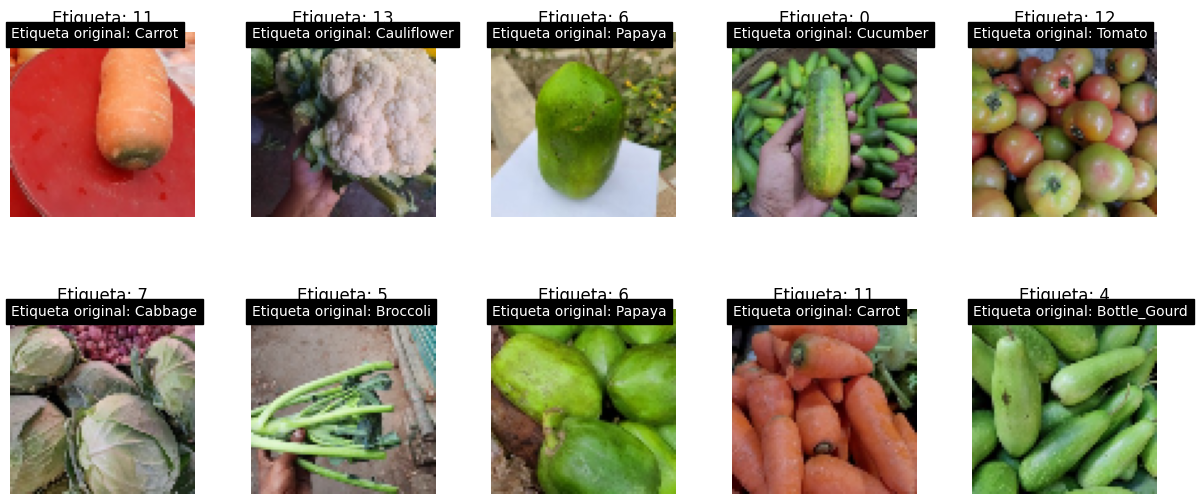

In [ ]:
# Número de ejemplos
num_samples = 10

# Generar lista de ejemplos aleatorios
random_indices = random.sample(range(len(x_train)), num_samples)

# Generar plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axes.flat):
    index = random_indices[i]

    # Mostrar
    ax.imshow(x_train[index])
    ax.set_title(f"Etiqueta: {y_train[index]}")
    ax.axis('off')
    original_label = classes[y_train[index]]
    ax.text(0, 2, f"Etiqueta original: {original_label}", color='white', backgroundcolor='black')

plt.show()

## 4.5 **Pasar etiquetas a one-hot encoding (OHE)**
Aplicar binarización a las etiquetas de los conjuntos de entrenamiento, validación y prueba, convirtiéndolas en representaciones de one-hot encoding, y mostrar la dimensión del conjunto de etiquetas de entrenamiento binarizadas.

In [ ]:
# Acondicionamiento/Binarización dataset

lb = LabelBinarizer()
y_train_ohe = lb.fit_transform(y_train)
y_val_ohe = lb.transform(y_val)
y_test_ohe = lb.transform(y_test)

print(y_train_ohe.shape)

(15000, 15)


## 4.6 **Data Augmentation - flow_from_directory**

Comentario: Aunque el preprocesamiento de los datos ya se haya realizado previamente para poder aplicarlo a aquellos modelos MLP o CNN sin aumentación de datos, se volverá a aplicar ahora el preprocesamiento utilizando ahora flow_from_directory(). Esto tiene como finalidad mostrar técnicas más allá de las vistas en los notebooks de clase y avanzadas que las vistas en clase y explorar metodologías alternativas a flow():

In [ ]:
# Definir el tamaño de lote y el tamaño de destino de la imagen como variables
batch_size_aug = 32

# Configuración de las técnicas de augmentation para train
## Train
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

## Validation
val_datagen = ImageDataGenerator(rescale=1./255)

## Test
test_datagen = ImageDataGenerator(rescale=1./255)


# Definir los generadores de train, validation y test
train_generator = train_datagen.flow_from_directory(
    '/content/my_dataset/Vegetable Images/train',
    target_size=target_size,
    batch_size=batch_size_aug,
    class_mode='categorical',
    shuffle = True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    '/content/my_dataset/Vegetable Images/validation',
    target_size=target_size,
    batch_size=batch_size_aug,
    class_mode='categorical',
    shuffle = True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    '/content/my_dataset/Vegetable Images/test',
    target_size=target_size,
    batch_size=batch_size_aug,
    class_mode='categorical',
    shuffle = False,
    seed=42
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


**Visualizar muestras generadas por data augmentation**

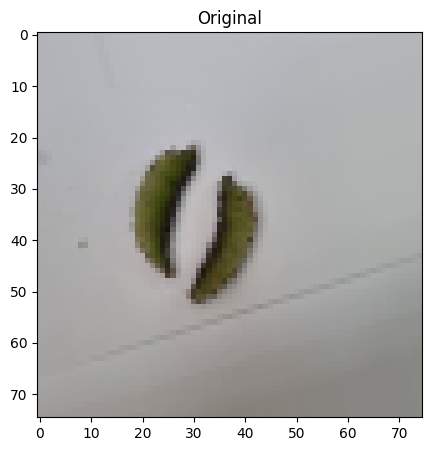

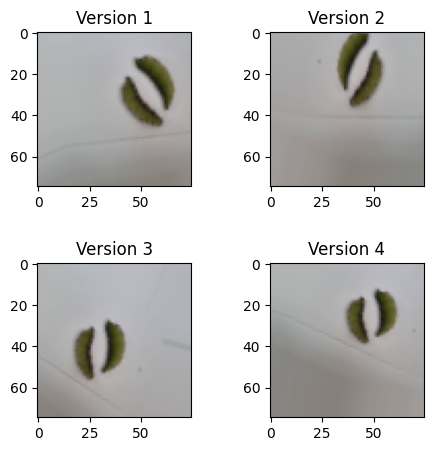

In [ ]:
# Seleccionar batch | almacenar imagen y label
images, labels = train_generator.next()

# Seleccionar imagen aleatoria del batch
random_index = np.random.randint(0, batch_size_aug)
original_image = images[random_index]

# Visualizar imagen original
plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.title("Original")

# Visualizar 4 augmentations de la imagen original
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

i = 0
for _ in range(4):
    augmented_image = train_datagen.random_transform(original_image)
    axes[i // 2, i % 2].imshow(augmented_image)
    axes[i // 2, i % 2].set_title(f'Version {i + 1}')
    i += 1

plt.show()

#**5. Estrategia 1: Entrenar desde cero o from scratch**


La primera estrategia a comparar será una red neuronal profunda que el alumno debe diseñar, entrenar y optimizar. Se debe justificar empíricamente las decisiones que llevaron a la selección de la arquitectura e hiperparámetros final. Se espera que el alumno utilice todas las técnicas de regularización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (weight regularization, dropout, batch normalization, data augmentation, etc.).

##**5.1 MLP**

### **5.1.1 MLP Base**

Construcción modelo MLP sin ningún tipo de normalización.

In [ ]:
# Función arquitectura MLP base
def get_mlp_model (dense_size, target_size, num_clases):

  model_mlp = Sequential()
  model_mlp.add(Flatten())
  model_mlp.add(Dense(dense_size, input_shape=target_size, activation = 'relu'))
  model_mlp.add(Dense(dense_size//2, activation = 'relu'))
  model_mlp.add(Dense(num_clases, activation = 'softmax'))

  return model_mlp

In [ ]:
# Entrenamiento MLP base

mlp_exp = "MLP_BASE_" + str(batch_size) + "_" + str(epochs)
exp_set.add(mlp_exp)

if do_training == True:

  model_mlp = get_mlp_model(dense_size, target_size, num_clases)

  model_mlp.compile(optimizer=Adam(learning_rate=learning_rate),
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

  print("[INFO]: Entrenando la red neuronal....")

  H = model_mlp.fit(x_train_norm, y_train_ohe,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=x_train_norm.shape[0] // batch_size,
                    validation_data=(x_val_norm, y_val_ohe),
                    callbacks=[early_stopping_cbck])

  save_trained_model(model = model_mlp, history = H, model_name = mlp_exp)

else:
    print("[INFO]: Cargando la red neuronal entrenada....")
    model_mlp = load_keras_model(mlp_exp)
    model_mlp.summary()
    H = load_history(mlp_exp)


[INFO]: Entrenando la red neuronal....
Epoch 1/50
58/58 [==============================] - 3s 28ms/step - loss: 2.7840 - accuracy: 0.2115 - val_loss: 2.1267 - val_accuracy: 0.3297
Epoch 2/50
58/58 [==============================] - 1s 16ms/step - loss: 1.9268 - accuracy: 0.3897 - val_loss: 1.8028 - val_accuracy: 0.4387
Epoch 3/50
58/58 [==============================] - 1s 21ms/step - loss: 1.7158 - accuracy: 0.4544 - val_loss: 1.6404 - val_accuracy: 0.4843
Epoch 4/50
58/58 [==============================] - 1s 21ms/step - loss: 1.5722 - accuracy: 0.5045 - val_loss: 1.5419 - val_accuracy: 0.5250
Epoch 5/50
58/58 [==============================] - 1s 19ms/step - loss: 1.4464 - accuracy: 0.5443 - val_loss: 1.4571 - val_accuracy: 0.5430
Epoch 6/50
58/58 [==============================] - 1s 22ms/step - loss: 1.3533 - accuracy: 0.5750 - val_loss: 1.3917 - val_accuracy: 0.5597
Epoch 7/50
58/58 [==============================] - 1s 21ms/step - loss: 1.2771 - accuracy: 0.5961 - val_loss: 1.39

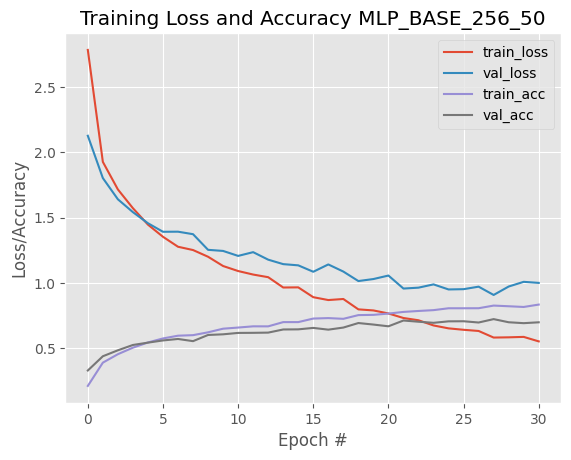

In [ ]:
visualize_learning_curve(H, lb = mlp_exp)

In [ ]:
# Evaluación MLP base

evaluate_model(model_mlp, x_test_norm, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       200
           1       0.68      0.56      0.62       200
           2       0.81      0.75      0.78       200
           3       0.77      0.85      0.81       200
           4       0.65      0.89      0.75       200
           5       0.79      0.61      0.69       200
           6       0.82      0.84      0.83       200
           7       0.44      0.72      0.55       200
           8       0.71      0.66      0.68       200
           9       0.70      0.37      0.49       200
          10       0.80      0.80      0.80       200
          11       0.87      0.93      0.90       200
          12       0.83      0.41      0.54       200
          13       0.68      0.58      0.63       200
          14       0.51      0.77      0.61       200

    accuracy                           0.69    

### **5.1.2 MLP Regularizado**

#### a) Dropout

In [ ]:
# Función arquitectura MLP regularizado

def get_mlp_model_drop(dense_size, target_size, num_clases, dropout_rate=0.25):

    model_mlp_drop = Sequential()
    model_mlp_drop.add(Flatten())
    model_mlp_drop.add(Dense(dense_size, input_shape=target_size,  activation='relu'))
    model_mlp_drop.add(Dropout(dropout_rate))  # 1er Dropout
    model_mlp_drop.add(Dense(dense_size // 2, activation='relu'))
    model_mlp_drop.add(Dropout(dropout_rate))  # 2do  Dropout
    model_mlp_drop.add(Dense(num_clases, activation='softmax'))

    return model_mlp_drop

In [ ]:
# Entrenamiento MLP con dropout

mlp_drop_exp = "MLP_DROP_" + str(batch_size) + "_" + str(epochs)
exp_set.add(mlp_drop_exp)

if do_training == True:

  mlp_model_drop = get_mlp_model_drop(dense_size, target_size, num_clases)

  mlp_model_drop.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss="categorical_crossentropy",
                         metrics=["accuracy"])

  print("[INFO]: Entrenando la red neuronal con dropout....")

  H_drop = mlp_model_drop.fit(x_train_norm, y_train_ohe, batch_size=batch_size,
                            epochs=epochs,
                            steps_per_epoch=x_train_norm.shape[0] // batch_size,
                            validation_data=(x_val_norm, y_val_ohe),
                            callbacks=[early_stopping_cbck])

  save_trained_model(model = mlp_model_drop, history = H_drop, model_name = mlp_drop_exp)

else:
    print("[INFO]: Cargando la red neuronal entrenada con dropout....")
    mlp_model_drop = load_keras_model(mlp_drop_exp)
    mlp_model_drop.summary()
    H_drop = load_history(mlp_drop_exp)


[INFO]: Entrenando la red neuronal con dropout....
Epoch 1/50
58/58 [==============================] - 10s 38ms/step - loss: 3.0316 - accuracy: 0.0988 - val_loss: 2.4926 - val_accuracy: 0.1597
Epoch 2/50
58/58 [==============================] - 1s 16ms/step - loss: 2.5205 - accuracy: 0.1411 - val_loss: 2.4131 - val_accuracy: 0.1933
Epoch 3/50
58/58 [==============================] - 1s 16ms/step - loss: 2.4240 - accuracy: 0.1588 - val_loss: 2.3112 - val_accuracy: 0.1887
Epoch 4/50
58/58 [==============================] - 1s 16ms/step - loss: 2.3586 - accuracy: 0.1926 - val_loss: 2.1839 - val_accuracy: 0.2877
Epoch 5/50
58/58 [==============================] - 1s 16ms/step - loss: 2.2883 - accuracy: 0.2176 - val_loss: 2.1499 - val_accuracy: 0.2977
Epoch 6/50
58/58 [==============================] - 1s 16ms/step - loss: 2.2503 - accuracy: 0.2263 - val_loss: 2.1156 - val_accuracy: 0.3043
Epoch 7/50
58/58 [==============================] - 1s 16ms/step - loss: 2.2067 - accuracy: 0.2349 - v

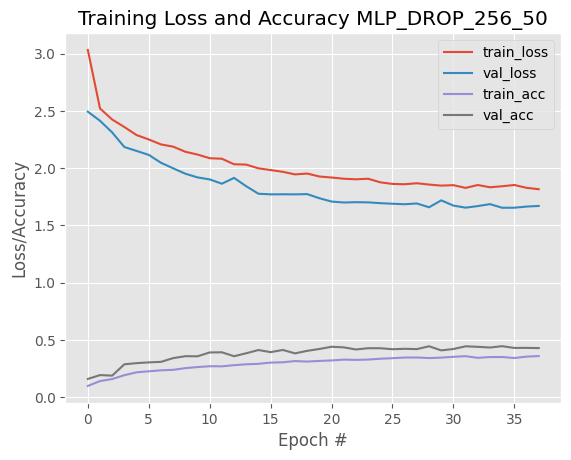

In [ ]:
visualize_learning_curve(H_drop, lb = mlp_drop_exp)

In [ ]:
# Evaluación MLP dropout

evaluate_model(mlp_model_drop, x_test_norm, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.25      0.17      0.20       200
           1       0.41      0.56      0.47       200
           2       0.53      0.65      0.58       200
           3       0.63      0.69      0.66       200
           4       0.79      0.47      0.59       200
           5       0.37      0.86      0.51       200
           6       0.38      0.41      0.40       200
           7       0.38      0.15      0.22       200
           8       0.22      0.59      0.33       200
           9       0.21      0.14      0.17       200
          10       0.78      0.40      0.53       200
          11       0.86      0.70      0.77       200
          12       0.29      0.37      0.33       200
          13       0.56      0.16      0.25       200
          14       0.20      0.01      0.03       200

    accuracy                           0.42    

#### **b) Regularización L1 o L2**

In [ ]:
# Función arquitectura MLP regularizado

def get_mlp_reg_model(dense_size, target_size, num_clases, drop_out_prop=0.05, reg_type='l1', reg_value=0.001):

    model_mlp_reg = Sequential()
    model_mlp_reg.add(Flatten())

    if reg_type == 'l2':
        reg = regularizers.l2(reg_value)
    elif reg_type == 'l1':
        reg = regularizers.l1(reg_value)
    else:
        raise ValueError("Input de regularización no válido")

    model_mlp_reg.add(Dense(dense_size, input_shape=target_size, kernel_regularizer=reg, activation='relu'))
    model_mlp_reg.add(Dense(dense_size // 2, kernel_regularizer=reg, activation='relu'))
    model_mlp_reg.add(Dropout(drop_out_prop))
    model_mlp_reg.add(Dense(num_clases, activation='softmax'))

    return model_mlp_reg

In [ ]:
# Entrenamiento MLP regularizado

mlp_reg_exp = "MLP_REG_" + str(batch_size) + "_" + str(epochs)
exp_set.add(mlp_reg_exp)

if do_training == True:

  mlp_model_reg = get_mlp_reg_model(dense_size, target_size, num_clases)

  mlp_model_reg.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss="categorical_crossentropy",
                         metrics=["accuracy"])

  print("[INFO]: Entrenando la red neuronal regularizada....")

  H_reg = mlp_model_reg.fit(x_train_norm, y_train_ohe, batch_size=batch_size,
                            epochs=epochs,
                            steps_per_epoch=x_train_norm.shape[0] // batch_size,
                            validation_data=(x_val_norm, y_val_ohe),
                            callbacks=[early_stopping_cbck])

  save_trained_model(model = mlp_model_reg, history = H_reg, model_name = mlp_reg_exp)

else:
    print("[INFO]: Cargando la red neuronal regularizada....")
    mlp_model_reg = load_keras_model(mlp_reg_exp)
    mlp_model_reg.summary()
    H_reg = load_history(mlp_reg_exp)

[INFO]: Entrenando la red neuronal regularizada....
Epoch 1/50
58/58 [==============================] - 4s 38ms/step - loss: 12.3719 - accuracy: 0.1636 - val_loss: 6.4086 - val_accuracy: 0.2860
Epoch 2/50
58/58 [==============================] - 1s 21ms/step - loss: 4.8901 - accuracy: 0.2539 - val_loss: 3.8355 - val_accuracy: 0.2677
Epoch 3/50
58/58 [==============================] - 1s 20ms/step - loss: 3.5111 - accuracy: 0.2790 - val_loss: 3.2588 - val_accuracy: 0.2897
Epoch 4/50
58/58 [==============================] - 1s 20ms/step - loss: 3.1670 - accuracy: 0.3129 - val_loss: 2.9379 - val_accuracy: 0.3623
Epoch 5/50
58/58 [==============================] - 1s 16ms/step - loss: 2.9711 - accuracy: 0.3340 - val_loss: 2.9019 - val_accuracy: 0.3290
Epoch 6/50
58/58 [==============================] - 1s 16ms/step - loss: 2.9548 - accuracy: 0.3370 - val_loss: 2.8766 - val_accuracy: 0.3760
Epoch 7/50
58/58 [==============================] - 1s 17ms/step - loss: 2.8022 - accuracy: 0.3590 - 

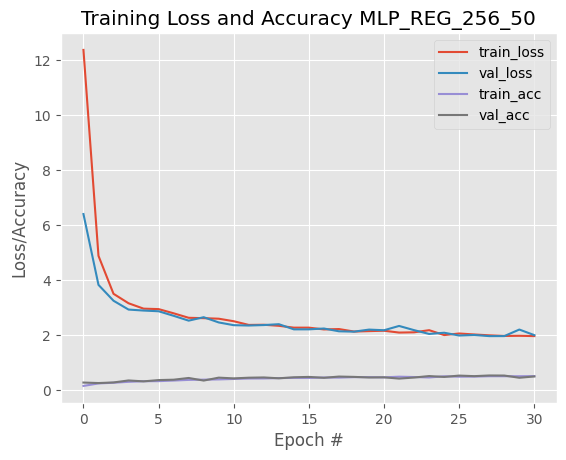

In [ ]:
visualize_learning_curve(H_reg, lb = mlp_reg_exp)

In [ ]:
## Evaluación MLP regularizado
evaluate_model(mlp_model_reg, x_test_norm, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.30      0.46      0.37       200
           1       0.59      0.56      0.58       200
           2       0.77      0.52      0.62       200
           3       0.59      0.55      0.57       200
           4       0.36      0.70      0.48       200
           5       0.74      0.47      0.57       200
           6       0.58      0.58      0.58       200
           7       0.37      0.24      0.29       200
           8       0.53      0.36      0.43       200
           9       0.36      0.18      0.24       200
          10       0.71      0.77      0.74       200
          11       0.77      0.86      0.82       200
          12       0.43      0.37      0.40       200
          13       0.44      0.48      0.46       200
          14       0.39      0.52      0.44       200

    accuracy                           0.51    

**Comentario resultados regularización L1 y L2**:<br>
Con regularización *L2* el modelo no mejora (L2_regularization_accuracy = 0.72 ; *non_regularization_accuracy* = 0.72). <br>
Con regularización *L1* el modelo empeora (*L2_regularization_accuracy* = 0.72 ; *non_regularization_accuracy* = 0.51).

Se han probado varios valores de regularización como 0.0001, 0.001, 0.009, 0.01
Se han encontrado que 0.001 devolvía los mejores resultados.

#### **c) Data Augmentation**

Entrenar modelo de perceptrón multicapa (MLP) regularizado utilizando técnicas de aumentación de datos (data augmentation).

In [ ]:
# Entrenamiento MLP con data augmentation

mlp_aug_exp = "MLP_AUG_" + str(batch_size) + "_" + str(epochs)
exp_set.add(mlp_aug_exp)

if do_training == True:

  model_mlp_aug = get_mlp_model(dense_size, target_size, num_clases)

  model_mlp_aug.compile(optimizer=Adam(learning_rate=learning_rate),
                          loss="categorical_crossentropy",
                          metrics=["accuracy"])

  print("[INFO]: Entrenando la red neuronal con data augmentation...")

  H_aug = model_mlp_aug.fit(train_generator,
                            steps_per_epoch=train_generator.samples // batch_size_aug,
                            validation_data=val_generator,
                            validation_steps=val_generator.samples // batch_size_aug,
                            epochs=epochs,
                            callbacks=[early_stopping_cbck])

  save_trained_model(model = model_mlp_aug, history = H_aug, model_name = mlp_aug_exp)

else:
  print("[INFO]: Cargando la red neuronal aumentada regularizada entrenada....")
  model_mlp_aug = load_keras_model(mlp_aug_exp)
  model_mlp_aug.summary()
  H_aug = load_history(mlp_aug_exp)

[INFO]: Entrenando la red neuronal con data augmentation...
Epoch 1/50
468/468 [==============================] - 55s 115ms/step - loss: 2.3297 - accuracy: 0.2503 - val_loss: 1.8618 - val_accuracy: 0.3582
Epoch 2/50
468/468 [==============================] - 53s 114ms/step - loss: 1.9133 - accuracy: 0.3520 - val_loss: 1.6799 - val_accuracy: 0.4331
Epoch 3/50
468/468 [==============================] - 54s 114ms/step - loss: 1.7804 - accuracy: 0.3924 - val_loss: 1.5322 - val_accuracy: 0.4671
Epoch 4/50
468/468 [==============================] - 51s 108ms/step - loss: 1.6633 - accuracy: 0.4374 - val_loss: 1.5268 - val_accuracy: 0.4657
Epoch 5/50
468/468 [==============================] - 52s 111ms/step - loss: 1.6143 - accuracy: 0.4560 - val_loss: 1.4553 - val_accuracy: 0.5027
Epoch 6/50
468/468 [==============================] - 52s 111ms/step - loss: 1.5391 - accuracy: 0.4855 - val_loss: 1.2962 - val_accuracy: 0.5662
Epoch 7/50
468/468 [==============================] - 51s 109ms/step -

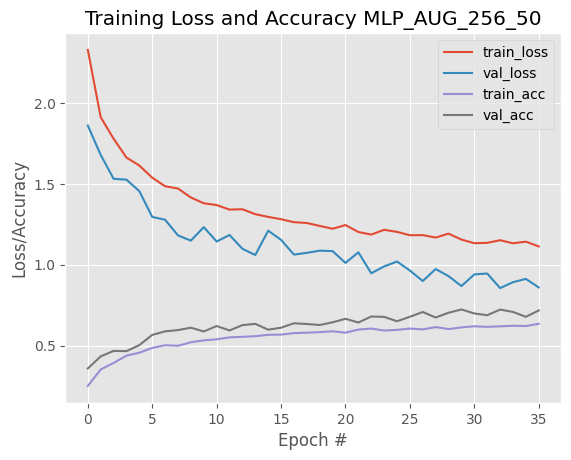

In [ ]:
visualize_learning_curve(H_aug, lb = mlp_aug_exp)

In [ ]:
# Evaluación MLP con data augmentation
evaluate_model_aug(model_mlp_aug, test_generator)

[INFO]: Evaluando red neuronal...


<ipython-input-4-e54c28b45500>:27: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, steps=len(generator))


              precision    recall  f1-score   support

           0       0.73      0.36      0.49       200
           1       0.54      0.77      0.64       200
           2       0.55      0.92      0.69       200
           3       0.79      0.69      0.73       200
           4       0.54      0.94      0.68       200
           5       0.72      0.58      0.64       200
           6       0.86      0.83      0.84       200
           7       0.89      0.99      0.94       200
           8       0.82      0.47      0.60       200
           9       0.77      0.46      0.58       200
          10       0.88      0.62      0.73       200
          11       0.87      0.82      0.85       200
          12       0.74      0.74      0.74       200
          13       0.74      0.89      0.80       200
          14       0.75      0.69      0.72       200

    accuracy                           0.72      3000
   macro avg       0.75      0.72      0.71      3000
weighted avg       0.75   

**Comentario:** <br>
Al aplicar data augmentation al MLP, se observa una convergencia más irregular debido a la mayor variabilidad de las imágenes introducida por esta técnica. A nivel global, se aprecia un incremento en la precisión (accuracy) tanto en los conjuntos de entrenamiento (train) como de validación. Asimismo, se constata una disminución en el error de pérdidas tanto en las fases de entrenamiento como de validación. Estos cambios indican una mejora potencial en la capacidad del modelo para generalizar, beneficiándose de un conjunto de datos más diverso y representativo.

##**5.2 CNNs**

###**5.2.1. Función arquitectura CNN**

**Comentario:**<br>
Obsérvese que la regularización `batch normalization` es uno de los parámetros de del modelo. La intención era hacer el modelo lo más funcional posible.
Se han explorado también las regularizaciones `dropout`, `L1` y `L2`. Sin embargo, ninguna de ellas aplicaba mejoras significativas a la perfomance. Cómo su implementación ya se ha mostrado en en el apartado **5.1)**, este apartado se ceñirá únicamente a la exploración del incremento de performance al añadir bloques convolucionales y `data augmentation` con `flow_from_directory`.

In [ ]:
# Función arquitectura de red CNN: soporta de 1 a 3 bloques convolucionales 2D simples con la opción de batch normalization

def get_cnn_model(blocks, x_train, num_clases, dense_size, batch_norm = False):

  input = layers.Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

  # Bloque 1
  x1 = layers.Conv2D(conv2d_size, (3,3), padding="same", activation="relu")(input)
  if batch_norm: x1 = layers.BatchNormalization()(x1)
  x1 = layers.MaxPooling2D(pool_size=(2,2))(x1)

  # Bloque 2
  x2 = layers.Conv2D(2*conv2d_size, (3,3), padding="same", activation="relu")(x1)
  if batch_norm: x2= layers.BatchNormalization()(x2)
  x2 = layers.MaxPooling2D(pool_size=(2,2))(x2)

  # Bloque 3
  x3 = layers.Conv2D(4*conv2d_size, (3,3), padding="same", activation="relu")(x2)
  if batch_norm: x3 = layers.BatchNormalization()(x3)
  x3 = layers.MaxPooling2D(pool_size=(2,2))(x3)

  # 2.TOP MODEL
  if blocks == 1: xfc = layers.Flatten()(x1)
  elif blocks == 2: xfc = layers.Flatten()(x2)
  elif blocks == 3:  xfc = layers.Flatten()(x3)
  else: return 'Arquitectura no valida'

  xfc = layers.Dense(dense_size, activation="relu")(xfc)

  predictions = layers.Dense(num_clases, activation="softmax")(xfc)

  return  Model(inputs=input, outputs=predictions)

###**5.2.2. 1CNN**

In [ ]:
# Entrenamiento 1 bloque CNN

n_cnn_blocks = 1
cnn_exp = str(n_cnn_blocks) + "CNN_" + str(batch_size) + "_" + str(epochs)
exp_set.add(cnn_exp)

if do_training == True:

  model_1cnn = get_cnn_model(n_cnn_blocks , x_train_norm,  num_clases, dense_size)

  model_1cnn.summary()

  model_1cnn.compile(optimizer=Adam(learning_rate=learning_rate),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

  print("[INFO]: Entrenando la red neuronal " + cnn_exp + "....")

  H = model_1cnn.fit(x_train_norm, y_train_ohe,
                     batch_size=batch_size,
                     epochs=epochs,
                     steps_per_epoch=x_train_norm.shape[0] // batch_size,
                     validation_data=(x_val_norm, y_val_ohe),
                     callbacks=[early_stopping_cbck])

  save_trained_model(model = model_1cnn, history = H, model_name = cnn_exp)

else:
  print("[INFO]: Cargando la red neuronal " + cnn_exp + "....")
  model_1cnn = load_keras_model(cnn_exp)
  model_1cnn.summary()
  H = load_history(cnn_exp)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 37, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 21904)             0         
                                                                 
 dense (Dense)               (None, 128)               2803840   
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                             

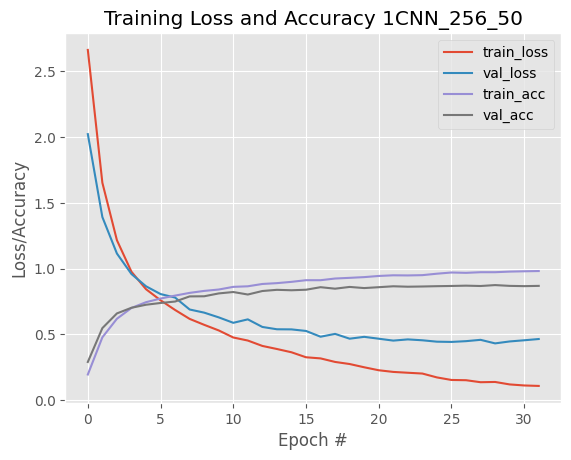

In [ ]:
visualize_learning_curve(H, lb = cnn_exp)

In [ ]:
# Evaluación 1CNN

evaluate_model(model_1cnn, x_test_norm, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       200
           1       0.90      0.80      0.85       200
           2       0.96      0.93      0.95       200
           3       0.87      0.96      0.92       200
           4       0.90      0.90      0.90       200
           5       0.87      0.83      0.85       200
           6       0.89      0.94      0.91       200
           7       0.85      0.73      0.79       200
           8       0.90      0.88      0.89       200
           9       0.69      0.92      0.79       200
          10       0.95      0.93      0.94       200
          11       0.99      0.98      0.99       200
          12       0.92      0.72      0.81       200
          13       0.71      0.77      0.73       200
          14       0.80      0.88      0.84       200

    accuracy                           0.86   

###**5.2.3. 2CNN**

In [ ]:
# Entrenamiento 2 bloque CNN

n_cnn_blocks = 2
cnn_exp = str(n_cnn_blocks) + "CNN_" + str(batch_size) + "_" + str(epochs)
exp_set.add(cnn_exp)


if do_training == True:

  model_2cnn = get_cnn_model(n_cnn_blocks , x_train_norm,  num_clases, dense_size)

  model_2cnn.summary()

  model_2cnn.compile(optimizer=Adam(learning_rate=learning_rate),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

  print("[INFO]: Entrenando la red neuronal " + cnn_exp + "....")

  H = model_2cnn.fit(x_train_norm, y_train_ohe,
                     batch_size=batch_size,
                     epochs=epochs,
                     steps_per_epoch=x_train_norm.shape[0] // batch_size,
                     validation_data=(x_val_norm, y_val_ohe),
                     callbacks=[early_stopping_cbck])

  save_trained_model(model = model_2cnn, history = H, model_name = cnn_exp)

else:
  print("[INFO]: Cargando la red neuronal " + cnn_exp + "....")
  model_2cnn = load_keras_model(cnn_exp)
  model_2cnn.summary()
  H = load_history(cnn_exp)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 37, 37, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 18, 18, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 10368)             0   

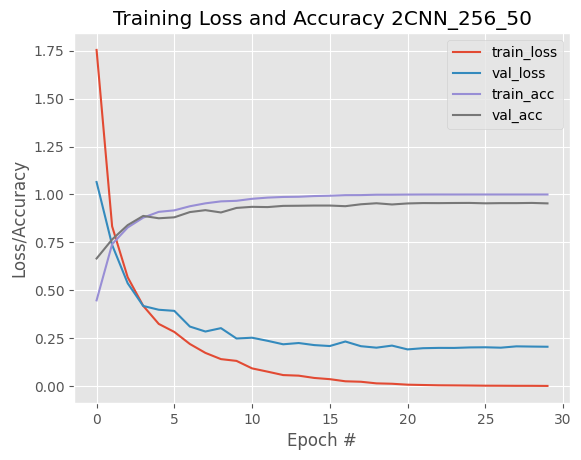

In [ ]:
visualize_learning_curve(H, lb = cnn_exp)

In [ ]:
# Evaluación 2CNN

evaluate_model(model_2cnn, x_test_norm, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       200
           1       0.94      0.94      0.94       200
           2       0.99      0.99      0.99       200
           3       0.98      0.99      0.99       200
           4       0.97      0.97      0.97       200
           5       0.92      0.94      0.93       200
           6       0.96      0.96      0.96       200
           7       0.94      0.95      0.95       200
           8       0.95      0.95      0.95       200
           9       0.90      0.94      0.92       200
          10       0.98      0.99      0.98       200
          11       1.00      1.00      1.00       200
          12       0.96      0.88      0.92       200
          13       0.91      0.92      0.91       200
          14       0.95      0.94      0.95       200

    accuracy                           0.95   

###**5.2.4. 3CNN**

##### **a) original**

In [ ]:
# Entrenamiento 3 bloques CNN

n_cnn_blocks = 3
cnn_exp = str(n_cnn_blocks) + "CNN_" + str(batch_size) + "_" + str(epochs)
exp_set.add(cnn_exp)

if do_training == True:

  model_3cnn = get_cnn_model(n_cnn_blocks , x_train_norm,  num_clases, dense_size)

  model_3cnn.summary()

  model_3cnn.compile(optimizer=Adam(learning_rate=learning_rate),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

  print("[INFO]: Entrenando la red neuronal " + cnn_exp + "....")

  H = model_3cnn.fit(x_train_norm, y_train_ohe,
                     batch_size=batch_size,
                     epochs=epochs,
                     steps_per_epoch=x_train_norm.shape[0] // batch_size,
                     validation_data=(x_val_norm, y_val_ohe),
                     callbacks=[early_stopping_cbck])

  save_trained_model(model = model_3cnn, history = H, model_name = cnn_exp)

else:
  print("[INFO]: Cargando la red neuronal " + cnn_exp + "....")
  model_3cnn = load_keras_model(cnn_exp)
  model_3cnn.summary()
  H = load_history(cnn_exp)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 37, 37, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 18, 18, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 64)        1849

KeyboardInterrupt: ignored

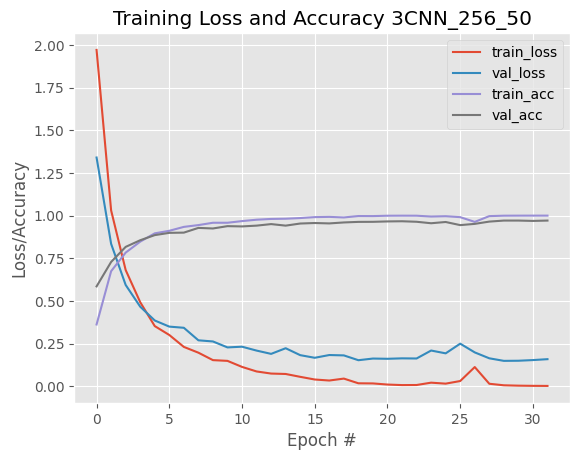

In [ ]:
visualize_learning_curve(H, lb = cnn_exp)

In [ ]:
# Evaluación 3CNN

evaluate_model(model_3cnn, x_test_norm, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       200
           1       0.94      0.93      0.93       200
           2       1.00      1.00      1.00       200
           3       0.98      0.98      0.98       200
           4       0.98      0.97      0.98       200
           5       0.92      0.95      0.93       200
           6       0.97      0.98      0.97       200
           7       0.95      0.95      0.95       200
           8       0.99      0.97      0.98       200
           9       0.93      0.96      0.95       200
          10       0.98      0.98      0.98       200
          11       1.00      0.99      1.00       200
          12       0.95      0.92      0.93       200
          13       0.94      0.94      0.94       200
          14       0.98      0.96      0.97       200

    accuracy                           0.97   

**Comentario:** El model_3cnn converge a partir de 32 épocas (en lugar de las 50 fijadas) gracias al `early stopping`.

#### **b) Batch Normalization**

In [ ]:
# Entrenamiento CNN de 3 bloques con Batch Normalization (batch_norm=True)

n_cnn_blocks = 3
cnn_exp = str(n_cnn_blocks) + "CNN_BN_" + str(batch_size) + "_" + str(epochs)
exp_set.add(cnn_exp)

if do_training == True:

  model_3cnn_batch_norm = get_cnn_model(n_cnn_blocks , x_train_norm,  num_clases, dense_size, batch_norm = True)

  model_3cnn_batch_norm.summary()

  model_3cnn_batch_norm.compile(optimizer=Adam(learning_rate=learning_rate),
                                loss="categorical_crossentropy",
                                metrics=["accuracy"])

  print("[INFO]: Entrenando la red neuronal " + cnn_exp + "....")

  H = model_3cnn_batch_norm.fit(x_train_norm, y_train_ohe,
                                batch_size=batch_size,
                                epochs=epochs,
                                steps_per_epoch=x_train_norm.shape[0] // batch_size,
                                validation_data=(x_val_norm, y_val_ohe),
                                callbacks=[early_stopping_cbck])

  save_trained_model(model = model_3cnn_batch_norm, history = H, model_name = cnn_exp)

else:
  print("[INFO]: Cargando la red neuronal " + cnn_exp + "....")
  model_3cnn_batch_norm = load_keras_model(cnn_exp)
  model_3cnn_batch_norm.summary()
  H = load_history(cnn_exp)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 75, 75, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 37, 37, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 37, 37, 32)        128 

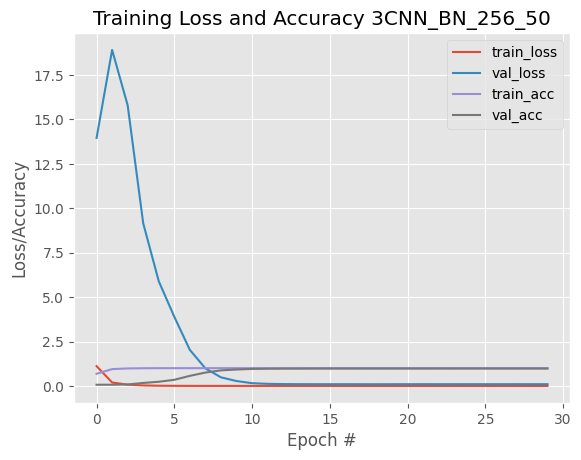

In [ ]:
visualize_learning_curve(H, lb = cnn_exp)

In [ ]:
evaluate_model(model_3cnn_batch_norm, x_test_norm, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       200
           1       0.95      0.94      0.95       200
           2       0.99      1.00      1.00       200
           3       0.99      1.00      1.00       200
           4       0.99      1.00      1.00       200
           5       0.95      0.98      0.97       200
           6       0.98      0.98      0.98       200
           7       0.98      0.94      0.96       200
           8       0.98      0.98      0.98       200
           9       0.98      0.98      0.98       200
          10       0.98      0.99      0.99       200
          11       1.00      1.00      1.00       200
          12       0.97      0.95      0.96       200
          13       0.97      0.97      0.97       200
          14       0.97      0.96      0.97       200

    accuracy                           0.98    

#### **c) CNN + Data Augmentation + Batch Norm**

Entrenar modelo CNN incorporando técnicas de aumentación de datos, lo que puede resultar en una convergencia más irregular debido a la diversidad y cantidad incrementada de imágenes. La aumentación de datos ayuda a la CNN a generalizar mejor, contribuyendo a una reducción general en las pérdidas de entrenamiento y validación. Las pérdidas más bajas en validación, en comparación con el entrenamiento, pueden deberse a que la aumentación introduce variabilidad en el conjunto de entrenamiento, mientras que el conjunto de validación, sin aumentar, refleja con mayor precisión la distribución natural de los datos.

In [ ]:
# Entrenamiento 3 bloques CNN AUG

# Entrenamiento CNN de 3 bloques con Data Augmentation y Batch Normalization

n_cnn_blocks = 3
cnn_exp = str(n_cnn_blocks) + "CNN_BN_AUG_" + str(batch_size) + "_" + str(epochs)
exp_set.add(cnn_exp)

if do_training == True:

  model_3cnn_aug = get_cnn_model(n_cnn_blocks , x_train_norm,  num_clases, dense_size, batch_norm = True)

  model_3cnn_aug.summary()

  model_3cnn_aug.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss="categorical_crossentropy",
                         metrics=["accuracy"])

  print("[INFO]: Entrenando la red neuronal " + cnn_exp + " con data augmentation...")

  H_aug = model_3cnn_aug.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size_aug,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size_aug,
                    epochs=epochs,
                    callbacks=[early_stopping_cbck])

  #save_trained_model(model = model_3cnn_aug, history = H_aug, model_name = cnn_exp)

else:
  print("[INFO]: Cargando la red neuronal " + cnn_exp + "....")
  model_3cnn_aug = load_keras_model(cnn_exp)
  model_3cnn_aug.summary()
  H_aug = load_history(cnn_exp)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 16)        448       
                                                                 
 batch_normalization_6 (Bat  (None, 75, 75, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 37, 37, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 37, 37, 32)        4640      
                                                                 
 batch_normalization_7 (Bat  (None, 37, 37, 32)        128 

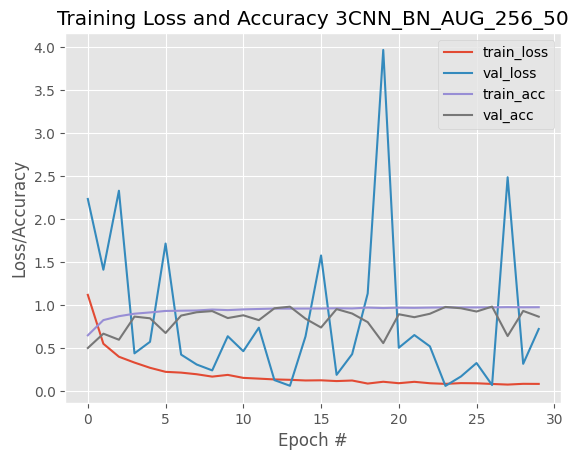

In [ ]:
visualize_learning_curve(H_aug, lb = cnn_exp)

In [ ]:
# Función de evaluación.
evaluate_model_aug(model_3cnn_aug, test_generator)

[INFO]: Evaluando red neuronal...


<ipython-input-4-e54c28b45500>:27: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, steps=len(generator))


              precision    recall  f1-score   support

           0       0.95      0.89      0.92       200
           1       0.78      0.97      0.86       200
           2       0.91      0.88      0.89       200
           3       0.91      0.92      0.91       200
           4       0.86      0.95      0.90       200
           5       0.79      0.89      0.84       200
           6       0.94      0.97      0.96       200
           7       0.98      0.95      0.96       200
           8       0.55      0.96      0.70       200
           9       0.99      0.79      0.88       200
          10       0.98      0.88      0.93       200
          11       0.96      0.69      0.80       200
          12       0.77      0.93      0.84       200
          13       1.00      0.31      0.47       200
          14       0.97      0.91      0.94       200

    accuracy                           0.86      3000
   macro avg       0.89      0.86      0.85      3000
weighted avg       0.89   

**Comentario:** El model_3cnn_batch_norma converge a partir de 32 épocas (en lugar de las 50 fijadas) gracias al `early stopping`.

# **6. Estrategia 2: Red pre-entrenada**

La segunda estrategia se basa en la utilización de una redes pre-entrenadas con el dataset ImageNet, llevando a cabo tareas de transfer learning y fine-tuning para resolver la tarea de clasificación.

Esta estrategia se divide en tres sub estrategias de entrenamiento:

- **Transfer Learning**: con dataset el original hacemos uso de características de alto nivel entrenadas en un perceptron multicapa de salida (top_model)transfiriendo directamente características de bajo nivel genéricas del *computer vision* dadas por la red prentrenada (base_model), cuyos pesos permancen congelados.
- **Fine Tuning parcial**: se descongela y entrena la red pre-entrenada (base_model) a partir de una capa convolucional dada junto con el perceptron multicapa de salida (top_model).
- **Fine Tuning completo**: se desconjela y entrena la red pre-entrenada (base_model)completamente junto con el perceptron multicapa de salida (top_model).

*Se espera el uso de todas las técnicas de regularización mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (weight regularization, dropout, batch normalization, data augmentation, etc.).*

La función **get_base_model** definida a continuación devuelve el base_model y sus pesos para una arquitectura dada pre-entrenada con el dataset imagenet, será reutilizada en todos los experimentos de esta sección.

In [ ]:
from tensorflow.keras.applications import vgg16, vgg19, resnet50, xception, inception_v3, inception_resnet_v2, mobilenet_v2, densenet, nasnet

# Cargar el base model y preprocesar los datos acorde a la red preentrenada
def get_base_model(base, x_train, x_val, x_test, weights="imagenet", include_top=False):
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    preprocess = None

    if base == 'VGG16':
        base_model = vgg16.VGG16(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = vgg16.preprocess_input

    elif base == 'VGG19':
        base_model = vgg19.VGG19(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = vgg19.preprocess_input

    elif base == 'ResNet50':
        base_model = resnet50.ResNet50(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = resnet50.preprocess_input

    elif base == 'Xception':
        base_model = xception.Xception(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = xception.preprocess_input

    elif base == 'InceptionV3':
        base_model = inception_v3.InceptionV3(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = inception_v3.preprocess_input

    elif base == 'InceptionResNetV2':
        base_model = inception_resnet_v2.InceptionResNetV2(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = inception_resnet_v2.preprocess_input

    elif base == 'MobileNetV2':
        base_model = mobilenet_v2.MobileNetV2(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = mobilenet_v2.preprocess_input

    elif base == 'DenseNet':
        base_model = densenet.DenseNet121(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = densenet.preprocess_input

    elif base == 'ResNet':
        base_model = resnet50.ResNet101(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = resnet50.preprocess_input

    elif base == 'NASNetLarge':
        base_model = nasnet.NASNetLarge(weights=weights, include_top=include_top, input_shape=input_shape)
        preprocess = nasnet.preprocess_input

    if preprocess is not None:
        # Aplicar el preprocesamiento a los datos de entrenamiento, validación y test
        x_train_preprocessed = preprocess(x_train)
        x_val_preprocessed = preprocess(x_val)
        x_test_preprocessed = preprocess(x_test)
    else:
        raise ValueError(f"Preprocesamiento para {base} no encontrado")

    base_model.summary()

    return base_model, x_train_preprocessed, x_val_preprocessed, x_test_preprocessed

##**6.1 Transfer Learning**

La función **get_pretrained_model** definida a continuación recibe un base_model, junto con el tamaño de la capa densa del top_model y el numero de clases de salida conectando ambas redes para realizar la tarea de transfer learning. Dado que estamos en una tarea de transfer learning, los pesos del base_model se mantienen congelados.

In [ ]:
def get_pretrained_model(base_model, dense_size, num_clases):

  # No entrenamos el base model
  base_model.trainable = False

  # Conectar el modelo con el top model
  pre_trained_model = Sequential()
  pre_trained_model.add(base_model)
  pre_trained_model.add(layers.Flatten())
  pre_trained_model.add(layers.Dense(dense_size, activation="relu"))
  pre_trained_model.add(layers.Dense(num_clases, activation="softmax"))

  pre_trained_model.summary()

  return pre_trained_model

###**6.1.1. VGG16**



#### **a) Original**

In [ ]:
# Obtención modelo pre entrenado VGG16
base = 'VGG16'
base_model, x_train_preprocessed, x_val_preprocessed, x_test_preprocessed = get_base_model(base, x_train, x_val, x_test)

pretrain_exp = base + "_TL_" + str(batch_size) + "_" + str(epochs)
exp_set.add(pretrain_exp)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [ ]:
# Entrenamiento modelo pre entrenado

if do_training == True:

  pre_trained_model = get_pretrained_model(base_model, dense_size, num_clases)

  pre_trained_model.compile(optimizer=Adam(learning_rate=learning_rate),
                            loss="categorical_crossentropy",
                            metrics=["accuracy"])

  print("[INFO]: Entrenando Top Model sobre ", base, " ...")

  H = pre_trained_model.fit(x_train_preprocessed, y_train_ohe,
                            batch_size=batch_size,
                            epochs=epochs,
                            steps_per_epoch=x_train_preprocessed.shape[0] // batch_size,
                            validation_data=(x_val_preprocessed, y_val_ohe),
                            callbacks=[early_stopping_cbck])

  save_trained_model(model = pre_trained_model, history = H, model_name = pretrain_exp)

else:
  print("[INFO]: Cargando Top Model sobre " + base + "....")
  pre_trained_model = load_keras_model(pretrain_exp)
  pre_trained_model.summary()
  H = load_history(pretrain_exp)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 15)                1935      
                                                                 
Total params: 14978895 (57.14 MB)
Trainable params: 264207 (1.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
[INFO]: Entrenando arquitectura sobre  VGG16  ...
Epoch 1/50
58/58 [==============================] - 12s 194ms/step - loss: 2.0115 - accurac

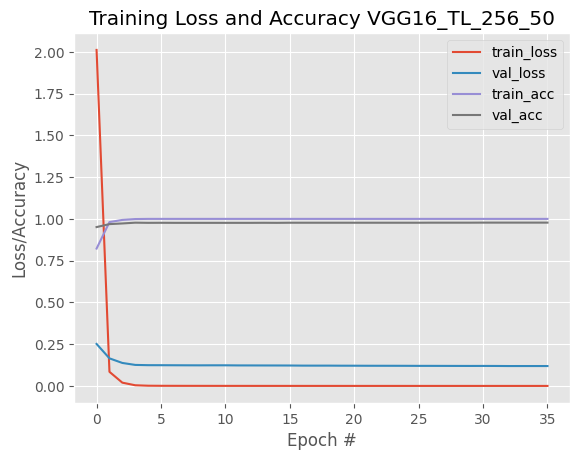

In [ ]:
visualize_learning_curve(H, lb =  pretrain_exp)

In [ ]:
# Evaluando modelo pre entrenado
evaluate_model(pre_trained_model, x_test_preprocessed, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 4s 102ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.98      0.95      0.97       200
           2       0.99      0.99      0.99       200
           3       0.99      0.99      0.99       200
           4       0.99      1.00      0.99       200
           5       1.00      0.99      1.00       200
           6       0.99      0.98      0.98       200
           7       0.99      0.98      0.99       200
           8       0.98      0.99      0.99       200
           9       0.99      0.99      0.99       200
          10       0.99      1.00      0.99       200
          11       0.99      0.99      0.99       200
          12       0.98      0.97      0.98       200
          13       0.98      0.98      0.98       200
          14       0.99      0.98      0.99       200

    accuracy                           0.99  

#### **b) Data Augmentation**

In [ ]:
# Entrenamiento modelo pre entrenado con data augmentation
pretrain_exp = base + "_TL_AUG_" + str(batch_size) + "_" + str(epochs)
exp_set.add(pretrain_exp)

if do_training == True:

  pre_trained_model_aug = get_pretrained_model(base_model, dense_size, num_clases)

  pre_trained_model_aug.compile(optimizer=Adam(learning_rate=learning_rate),
                                loss="categorical_crossentropy",
                                metrics=["accuracy"])

  print("[INFO]: Entrenando Top Model sobre ", base, " con data augmentation")
  H_aug = pre_trained_model_aug.fit(train_generator,
                                    steps_per_epoch=train_generator.samples // batch_size_aug,
                                    validation_data=val_generator,
                                    validation_steps=val_generator.samples // batch_size_aug,
                                    epochs=epochs,
                                    callbacks=[early_stopping_cbck])

  save_trained_model(model = pre_trained_model, history = H, model_name = pretrain_exp)

else:
  print("[INFO]: Cargando Top Model sobre " +  base, " con data augmentation")
  pre_trained_model_aug = load_keras_model(pretrain_exp)
  pre_trained_model_aug.summary()
  H_aug = load_history(pretrain_exp)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 15)                1935      
                                                                 
Total params: 14978895 (57.14 MB)
Trainable params: 264207 (1.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
[INFO]: Entrenando MLP sobre  VGG16  con data augmentation
Epoch 1/50
468/468 [==============================] - 65s 136ms/step - loss: 0.928

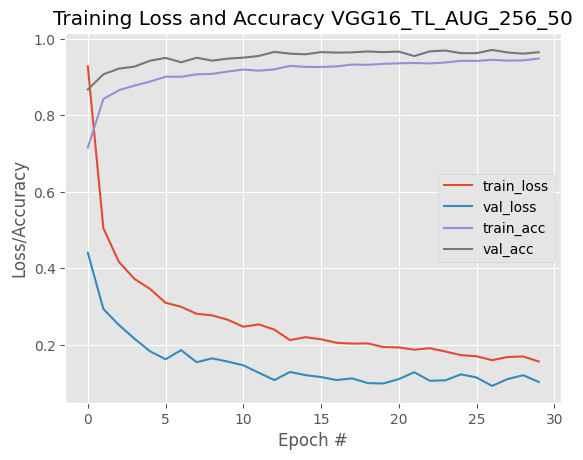

In [ ]:
visualize_learning_curve(H_aug, lb = pretrain_exp)

In [ ]:
# Evaluar el modelo
evaluate_model_aug(pre_trained_model_aug, test_generator)

[INFO]: Evaluando red neuronal...


<ipython-input-4-e54c28b45500>:27: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, steps=len(generator))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       200
           1       0.97      0.99      0.98       200
           2       0.98      1.00      0.99       200
           3       0.99      0.92      0.95       200
           4       0.97      0.99      0.98       200
           5       0.95      0.98      0.96       200
           6       0.99      0.98      0.99       200
           7       0.99      0.99      0.99       200
           8       0.90      0.98      0.94       200
           9       0.98      0.98      0.98       200
          10       0.93      0.98      0.95       200
          11       0.98      0.98      0.98       200
          12       0.98      0.87      0.92       200
          13       1.00      0.98      0.99       200
          14       0.97      0.97      0.97       200

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97   

###**6.1.2. Xception**

In [ ]:
# Obtención modelo pre entrenado Xception
base = 'Xception'
base_model, x_train_preprocessed, x_val_preprocessed, x_test_preprocessed = get_base_model(base, x_train, x_val, x_test)

pretrain_exp = base + "_TL_" + str(batch_size) + "_" + str(epochs)
exp_set.add(pretrain_exp)

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 37, 37, 32)           864       ['input_8[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 37, 37, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [ ]:
# Entrenamiento modelo pre entrenado

if do_training == True:

  pre_trained_model = get_pretrained_model(base_model, dense_size, num_clases)

  pre_trained_model.compile(optimizer=Adam(learning_rate=learning_rate),
                            loss="categorical_crossentropy",
                            metrics=["accuracy"])

  print("[INFO]: Entrenando Top Model sobre ", base, " ...")

  H = pre_trained_model.fit(x_train_preprocessed, y_train_ohe,
                            batch_size=batch_size,
                            epochs=epochs,
                            steps_per_epoch=x_train_preprocessed.shape[0] // batch_size,
                            validation_data=(x_val_preprocessed, y_val_ohe),
                            callbacks=[early_stopping_cbck])

#  save_trained_model(model = pre_trained_model, history = H, model_name = pretrain_exp)

else:
  print("[INFO]: Cargando Top Model sobre " + base + "....")
  pre_trained_model = load_keras_model(pretrain_exp)
  pre_trained_model.summary()
  H = load_history(pretrain_exp)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten_6 (Flatten)         (None, 18432)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               2359424   
                                                                 
 dense_13 (Dense)            (None, 15)                1935      
                                                                 
Total params: 23222839 (88.59 MB)
Trainable params: 2361359 (9.01 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________
[INFO]: Entrenando Top Model sobre  Xception  ...
Epoch 1/50
58/58 [==============================] - 15s 208ms/step - loss: 1.3544 - accura

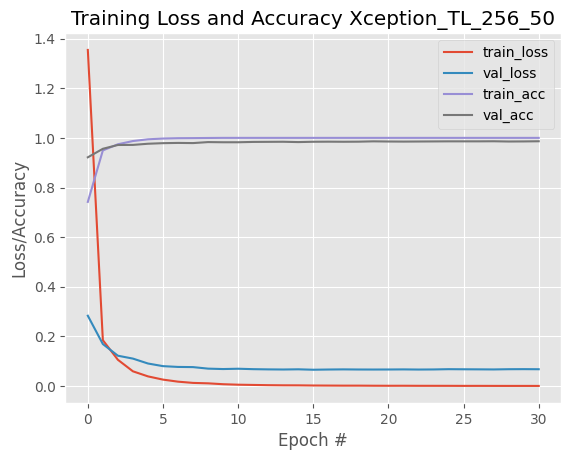

In [ ]:
visualize_learning_curve(H, lb =  pretrain_exp)

In [ ]:
# Evaluando modelo pre entrenado
evaluate_model(pre_trained_model, x_test_preprocessed, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 5s 100ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       200
           1       0.98      0.98      0.98       200
           2       1.00      0.95      0.98       200
           3       0.99      0.98      0.99       200
           4       0.99      0.99      0.99       200
           5       0.96      0.96      0.96       200
           6       0.99      0.97      0.98       200
           7       0.97      0.97      0.97       200
           8       0.97      0.98      0.98       200
           9       0.95      0.98      0.97       200
          10       0.99      0.99      0.99       200
          11       0.99      0.99      0.99       200
          12       0.98      0.97      0.98       200
          13       0.98      0.98      0.98       200
          14       0.97      1.00      0.98       200

    accuracy                           0.98  

###**6.1.3. InceptionV3**

In [ ]:
# Obtención modelo pre entrenado InceptionV3

base = 'InceptionV3'
base_model, x_train_preprocessed, x_val_preprocessed, x_test_preprocessed = get_base_model(base, x_train, x_val, x_test)

pretrain_exp = base + "_TL_" + str(batch_size) + "_" + str(epochs)
exp_set.add(pretrain_exp)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 37, 37, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 37, 37, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 37, 37, 32)           0         ['batch_normalizati

In [ ]:
# Entrenamiento modelo pre entrenado

if do_training == True:

  pre_trained_model = get_pretrained_model(base_model, dense_size, num_clases)

  pre_trained_model.compile(optimizer=Adam(learning_rate=learning_rate),
                            loss="categorical_crossentropy",
                            metrics=["accuracy"])

  print("[INFO]: Entrenando Top Model sobre ", base, " ...")

  H = pre_trained_model.fit(x_train_preprocessed, y_train_ohe,
                            batch_size=batch_size,
                            epochs=epochs,
                            steps_per_epoch=x_train_preprocessed.shape[0] // batch_size,
                            validation_data=(x_val_preprocessed, y_val_ohe),
                            callbacks=[early_stopping_cbck])

  save_trained_model(model = pre_trained_model, history = H, model_name = pretrain_exp)

else:
  print("[INFO]: Cargando Top Model sobre " + base + "....")
  pre_trained_model = load_keras_model(pretrain_exp)
  pre_trained_model.summary()
  H = load_history(pretrain_exp)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 22066991 (84.18 MB)
Trainable params: 264207 (1.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
[INFO]: Entrenando MLP sobre  InceptionV3  ...
Epoch 1/50
58/58 [==============================] - 24s 150ms/step - loss: 1.0763 - accuracy: 0.

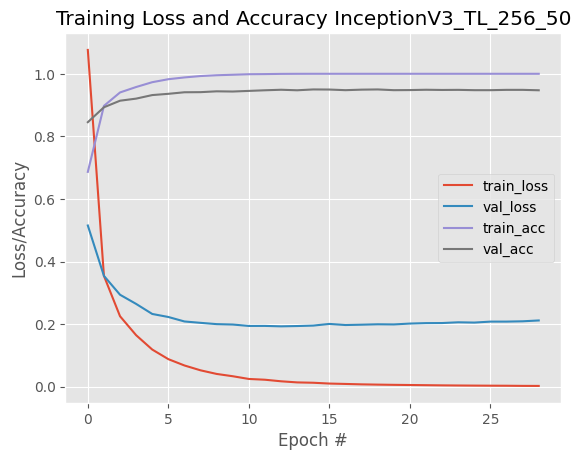

In [ ]:
visualize_learning_curve(H, lb = pretrain_exp)

In [ ]:
# Evaluando modelo pre entrenado
evaluate_model(pre_trained_model, x_test_preprocessed, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 4s 58ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       200
           1       0.94      0.90      0.92       200
           2       0.97      0.95      0.96       200
           3       0.98      0.97      0.98       200
           4       0.96      0.98      0.97       200
           5       0.93      0.94      0.93       200
           6       0.94      0.91      0.92       200
           7       0.90      0.95      0.92       200
           8       0.95      0.94      0.94       200
           9       0.93      0.97      0.95       200
          10       0.98      0.97      0.98       200
          11       0.97      1.00      0.99       200
          12       0.94      0.94      0.94       200
          13       0.95      0.93      0.94       200
          14       0.93      0.92      0.92       200

    accuracy                           0.95   

###**6.1.4. ResNet50**

In [ ]:
# Obtención modelo pre entrenado InceptionV3
base = 'ResNet50'
base_model, x_train_preprocessed, x_val_preprocessed, x_test_preprocessed = get_base_model(base, x_train, x_val, x_test)

pretrain_exp = base + "_TL_" + str(batch_size) + "_" + str(epochs)
exp_set.add(pretrain_exp)

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 81, 81, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 38, 38, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 38, 38, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
# Entrenamiento modelo pre entrenado

if do_training == True:

  pre_trained_model = get_pretrained_model(base_model, dense_size, num_clases)

  pre_trained_model.compile(optimizer=Adam(learning_rate=learning_rate),
                            loss="categorical_crossentropy",
                            metrics=["accuracy"])

  print("[INFO]: Entrenando Top Model sobre ", base, " ...")
  H = pre_trained_model.fit(x_train_preprocessed, y_train_ohe,
                            batch_size=batch_size,
                            epochs=epochs,
                            steps_per_epoch=x_train_preprocessed.shape[0] // batch_size,
                            validation_data=(x_val_preprocessed, y_val_ohe),
                            callbacks=[early_stopping_cbck])

  save_trained_model(model = pre_trained_model, history = H, model_name = pretrain_exp)

else:
  print("[INFO]: Cargando Top Model sobre " + base + "....")
  pre_trained_model = load_keras_model(pretrain_exp)
  pre_trained_model.summary()
  H = load_history(pretrain_exp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2359424   
                                                                 
 dense_3 (Dense)             (None, 15)                1935      
                                                                 
Total params: 25949071 (98.99 MB)
Trainable params: 2361359 (9.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
[INFO]: Entrenando MLP sobre  ResNet50  ...
Epoch 1/50
58/58 [==============================] - 18s 201ms/step - loss: 2.5815 - accuracy: 0.

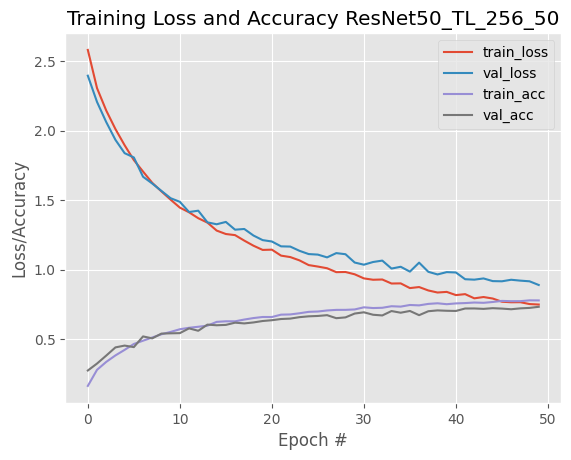

In [ ]:
visualize_learning_curve(H, lb = pretrain_exp)

In [ ]:
# Evaluar modelo
evaluate_model(pre_trained_model, x_test_preprocessed, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 4s 81ms/step
              precision    recall  f1-score   support

           0       0.81      0.64      0.71       200
           1       0.75      0.63      0.69       200
           2       0.65      0.81      0.72       200
           3       0.93      0.76      0.83       200
           4       0.84      0.90      0.87       200
           5       0.75      0.66      0.70       200
           6       0.83      0.75      0.79       200
           7       0.66      0.55      0.60       200
           8       0.64      0.74      0.68       200
           9       0.72      0.72      0.72       200
          10       0.62      0.87      0.72       200
          11       0.79      0.82      0.81       200
          12       0.63      0.56      0.59       200
          13       0.73      0.63      0.68       200
          14       0.62      0.79      0.69       200

    accuracy                           0.72   

Con la arquitectura ResNet50 se obtiene una convergencia muy lenta del modelo.

##**6.2 Fine Tuning parcial**

La función **get_fine_tuned_model** definida a continuación recibe un base_model, junto con el tamaño de la capa densa entrenable del top_model, el numero de clases de salida, y la primera capa entrenable del base_model, conectando ambas redes para realizar la tarea de fine tuning. Dado que estamos en una tarea de fine tuning parcial, se entrenarán los pesos del base_model a partir de la primera capa entrenable hasta el top_model, manteniendose el resto de pesos del base_model congelados.

In [ ]:
def get_fine_tuned_model(base_model, first_trainable_layer, dense_size, num_clases):

  for layer in base_model.layers:
    if layer.name == first_trainable_layer:
      break
    layer.trainable = False
    print("Capa " + layer.name + " congelada...")

  fine_tuned_model = Sequential()
  fine_tuned_model.add(base_model)
  fine_tuned_model.add(layers.Flatten())
  fine_tuned_model.add(layers.Dense(dense_size, activation="relu"))
  fine_tuned_model.add(layers.Dense(num_clases, activation="softmax"))

  fine_tuned_model.summary()

  return fine_tuned_model

###**6.2.1. VGG16**

In [ ]:
# Elegir modelo base
base = 'VGG16'
first_trainable_layer = "block4_conv1"

# Cargar modelo base y preprocesar datos
base_model, x_train_preprocessed, x_val_preprocessed, x_test_preprocessed = get_base_model(base, x_train, x_val, x_test)

finetuning_exp = base + "_FT_" + first_trainable_layer + "_" + str(batch_size) + "_" + str(epochs)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [ ]:
# Compilamos el modelo y entrenamos

if do_training == True:

  fine_tuned_model = get_fine_tuned_model(base_model, first_trainable_layer, dense_size, num_clases)

  fine_tuned_model.compile(optimizer=Adam(learning_rate=learning_rate),
                           loss="categorical_crossentropy",
                           metrics=["accuracy"])

  print("[INFO]: Entrenando " + base + " desde " + first_trainable_layer + " +  MLP ...")
  H = fine_tuned_model.fit(x_train_preprocessed, y_train_ohe,
                            batch_size=batch_size,
                            epochs=epochs,
                            steps_per_epoch=x_train_preprocessed.shape[0] // batch_size,
                            validation_data=(x_val_preprocessed, y_val_ohe),
                            callbacks=[early_stopping_cbck])

  save_trained_model(model = fine_tuned_model, history = H, model_name = finetuning_exp)

else:
  print("[INFO]: Cargando " + base + " desde " + first_trainable_layer + " +  MLP ...")
  fine_tuned_model = load_keras_model(finetuning_exp)
  fine_tuned_model.summary()
  H = load_history(finetuning_exp)



Capa input_3 congelada...
Capa block1_conv1 congelada...
Capa block1_conv2 congelada...
Capa block1_pool congelada...
Capa block2_conv1 congelada...
Capa block2_conv2 congelada...
Capa block2_pool congelada...
Capa block3_conv1 congelada...
Capa block3_conv2 congelada...
Capa block3_conv3 congelada...
Capa block3_pool congelada...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 15)                1935      
                                                   

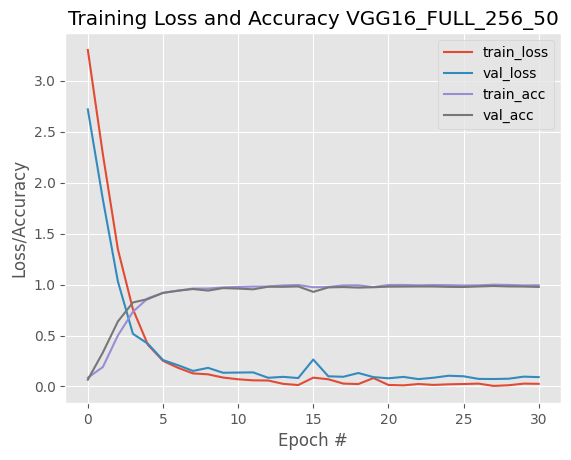

In [ ]:
visualize_learning_curve(H, lb = finetuning_exp)

In [ ]:
# Evaluar modelo
evaluate_model(pre_trained_model, x_test_preprocessed, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 2s 64ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       200
           1       0.98      0.96      0.97       200
           2       0.95      0.99      0.97       200
           3       0.98      0.97      0.98       200
           4       0.99      1.00      0.99       200
           5       0.98      0.97      0.98       200
           6       0.98      0.97      0.97       200
           7       0.95      0.98      0.97       200
           8       0.99      0.95      0.97       200
           9       0.98      0.97      0.97       200
          10       1.00      1.00      1.00       200
          11       0.99      0.98      0.98       200
          12       0.96      0.97      0.97       200
          13       0.95      0.96      0.96       200
          14       0.98      0.98      0.98       200

    accuracy                           0.98   

## **6.3 Fine Tuning Completo**

La función **get_fine_tuned_model_full** definida a continuación recibe un base_model, junto con el tamaño de la capa densa entrenable del top_model y el numero de clases de salida conectando ambas redes para realizar la tarea de fine tuning. Dado que estamos en una tarea de fine tuning completo, se entrenarán los todos pesos del base_model a partir de la primera capa entrenable hasta el top_model.

In [ ]:
def get_fine_tuned_model_full(base_model, dense_size, num_clases):

  base_model.trainable = True

  fine_tuned_model = Sequential()
  fine_tuned_model.add(base_model)
  fine_tuned_model.add(layers.Flatten())
  fine_tuned_model.add(layers.Dense(dense_size, activation="relu"))
  fine_tuned_model.add(layers.Dense(num_clases, activation="softmax"))

  fine_tuned_model.summary()

  return fine_tuned_model

###**6.3.1. VGG16**

In [ ]:
# Elegir modelo base
base = 'VGG16'
# Cargar modelo base y preprocesar datos acorde al modelo base
base_model, x_train_preprocessed, x_val_preprocessed, x_test_preprocessed = get_base_model(base, x_train, x_val, x_test)

finetuning_exp = base + "_FULL_" + str(batch_size) + "_" + str(epochs)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [ ]:
# Entrenamos la red
if do_training == True:

# Cargar modelo base
  fine_tuned_model = get_fine_tuned_model_full(base_model, dense_size, num_clases)

  fine_tuned_model.compile(optimizer=Adam(learning_rate=learning_rate),
                           loss="categorical_crossentropy",
                           metrics=["accuracy"])

  print("[INFO]: Entrenando " + base + " completo + MLP...")

  H = fine_tuned_model.fit(x_train_preprocessed, y_train_ohe,
                            batch_size=batch_size,
                            epochs=epochs,
                            steps_per_epoch=x_train_preprocessed.shape[0] // batch_size,
                            validation_data=(x_val_preprocessed, y_val_ohe),
                            callbacks=[early_stopping_cbck])

  save_trained_model(model = fine_tuned_model, history = H, model_name = finetuning_exp)

else:
  print("[INFO]: Entrenando " + base + " completo + MLP...")
  fine_tuned_model = load_keras_model(finetuning_exp)
  fine_tuned_model.summary()
  H = load_history(finetuning_exp)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 14978895 (57.14 MB)
Trainable params: 14978895 (57.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
[INFO]: Entrenando VGG16 completo + MLP...
Epoch 1/50
58/58 [==============================] - 52s 483ms/step - loss: 2.5372 - accuracy: 0.1204 - 

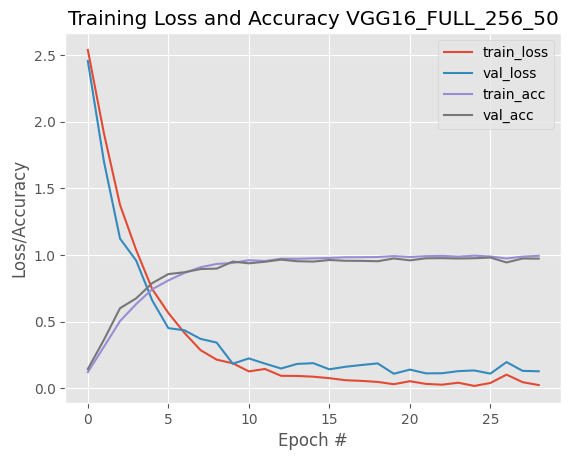

In [ ]:
visualize_learning_curve(H, lb = finetuning_exp)

In [ ]:
# Evaluar modelo
evaluate_model(pre_trained_model, x_test_preprocessed, y_test)

[INFO]: Evaluando red neuronal...
24/24 [==============================] - 4s 98ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.93      0.95       200
           2       0.99      0.99      0.99       200
           3       0.99      0.99      0.99       200
           4       0.93      1.00      0.96       200
           5       0.96      0.99      0.98       200
           6       0.96      0.96      0.96       200
           7       0.95      0.97      0.96       200
           8       0.98      0.96      0.97       200
           9       0.97      0.96      0.97       200
          10       0.94      0.99      0.97       200
          11       0.98      0.98      0.98       200
          12       0.95      0.90      0.92       200
          13       0.98      0.96      0.97       200
          14       0.98      0.93      0.95       200

    accuracy                           0.97   

# **7. Exportación de Resultados**

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [ ]:
name_IPYNB_file = '07MIAR_Proyecto_Programacion.ipynb'
!jupyter nbconvert --to pdf '$BASE_FOLDER''$name_IPYNB_file' --to pdf

[NbConvertApp] CRITICAL | Bad config encountered during initialization: Error loading argument NbConvertApp.export_format=['pdf', 'pdf'], export_format only accepts one value, got 2: ['pdf', 'pdf']


In [ ]:
BASE_FOLDER

'/content/drive/MyDrive/07MIAR_Proyecto_Programacion/'